## Benchmark Analysis 

The main purpose of this notebook is to propose a benchmark strategy for a real use case scenario. We have tested and benchmarked data from three different providers so far:

1. Climate Data Store (CDS) - https://github.com/ecmwf/cdsapi

2. Google Cloud Platform (GCP) - https://github.com/google-research/arco-era5/blob/main/docs/0-Surface-Reanalysis-Walkthrough.ipynb
3. Microsoft Planetary Computer - https://planetarycomputer.microsoft.com/dataset/era5-pds#Example-Notebook
4. ToDo: Include benchmarking for AWS - 

We utilized the Python APIs provided by each of these data sources. To enhance flexibility and support potential future extensions, these APIs have been encapsulated within Python classes.

A general configuration file is used to manage and perform the benchmarks according to a specified set of parameters. Each provider has a dedicated Python script that runs the benchmark, returning the results as a JSON file. These JSON files are then analyzed within this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Parameters of the benchmark
- start: 2020-05-01T00
- end: 2020-05-31T00
- frequence: "D"
- variables: ["10m_u_component_of_wind","10m_v_component_of_wind"]

### Read benchmark results from all ERA5 data provider

In [16]:
df_cds = pd.read_json("cds/cds_benchmark.json")
df_cds["provider"] = "CDS"
df_cds["end_to_end_std"] = df_cds["end_to_end"].std()
df_gcp = pd.read_json("gcp/gcp_benchmark.json")
df_gcp["end_to_end_std"] = df_gcp["end_to_end"].std()
df_gcp["provider"] = "Google"
df_m = pd.read_json("microsoft/gcp_benchmark.json")
df_m["end_to_end_std"] = df_m["end_to_end"].std()
df_m["provider"] = "Microsoft"
df = pd.concat([df_cds, df_gcp, df_m ], axis=0)
df

,download_time,data_processing,animation,end_to_end,request_issues,provider,end_to_end_std
0,5.693968,1.148738,48.248924,55.091630,0,CDS,3.596953
1,11.727996,0.586247,48.105650,60.419893,0,CDS,3.596953
2,7.968933,0.590240,48.358934,56.918106,0,CDS,3.596953
3,5.959615,0.588420,48.224382,54.772417,0,CDS,3.596953
4,6.822927,0.591347,47.614859,55.029133,0,CDS,3.596953
5,8.922319,0.592983,47.736456,57.251758,0,CDS,3.596953
6,11.363349,0.597504,48.122834,60.083688,0,CDS,3.596953
7,18.136941,0.614610,47.866174,66.617725,0,CDS,3.596953
8,10.632106,0.771182,48.400382,59.803670,0,CDS,3.596953
9,8.827003,0.605006,47.925130,57.357139,0,CDS,3.596953


Compute the mean value for each data provider

In [17]:
df = df.groupby('provider').mean().reset_index()
df

,provider,download_time,data_processing,animation,end_to_end,request_issues,end_to_end_std
0,CDS,9.605516,0.668628,48.060372,58.334516,0.0,3.596953
1,Google,43.496497,0.075503,48.014941,91.586941,0.0,1.086373
2,Microsoft,42.217257,0.074126,47.778921,90.070304,0.0,3.150244


### Plot data provider benchnark result


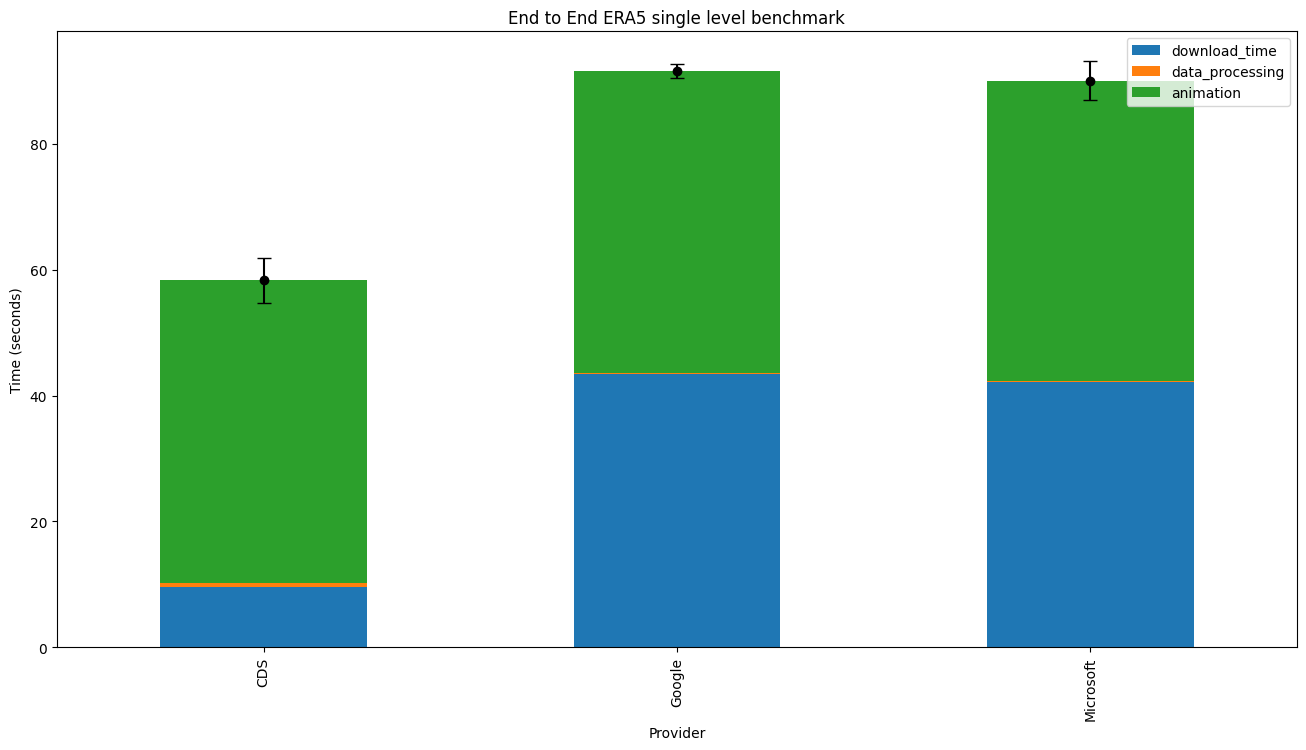

In [18]:
errors = df['end_to_end_std']
# Plotting the stacked bar chart without 'end_to_end'
df_plot = df.drop(columns=['end_to_end', 'end_to_end_std','request_issues'])
df_plot.plot(kind='bar', stacked=True, figsize=(16, 8))

# Overlay 'end_to_end' with error bars
x = np.arange(len(df))
plt.errorbar(x, df['end_to_end'], yerr=errors, fmt='o', color='black', capsize=5)

# Set labels and title
plt.ylabel('Time (seconds)')
plt.title('End to End ERA5 single level benchmark')
plt.xlabel("Provider")

# Adding city names as x-tick labels
plt.xticks(x, df['provider'])

# Display legend
plt.legend(loc='upper right')

# Save the figure
plt.show()

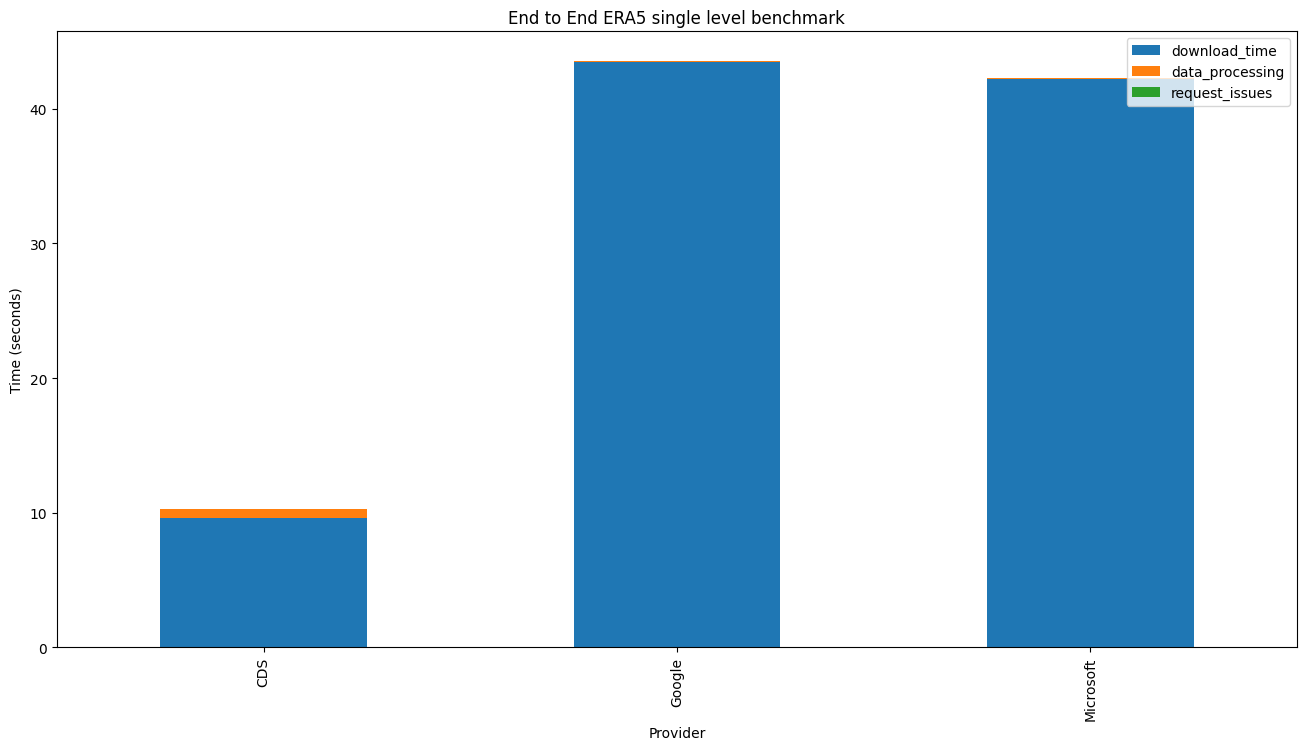

In [19]:
# Plotting the stacked bar chart without 'end_to_end'
df_plot = df.drop(columns=['end_to_end', 'end_to_end_std',"animation"])
df_plot.plot(kind='bar', stacked=True, figsize=(16, 8))
# Set labels and title
plt.ylabel('Time (seconds)')
plt.title('End to End ERA5 single level benchmark')
plt.xlabel("Provider")
# Adding city names as x-tick labels
plt.xticks(x, df['provider'])
# Display legend
plt.legend(loc='upper right')
# Save the figure
plt.show()

- Processing Time: The Climate Data Store (CDS) is approximately 10 times slower than Google Cloud Platform (GCP) and Microsoft Planetary Computer. This is primarily because CDS data needs to be opened and loaded into memory using Xarray.

- Data Access Strategy: The main difference between CDS and the other providers lies in their data access strategies. For Microsoft and Google, users directly access a Zarr dataset, allowing for immediate and efficient data manipulation. In contrast, CDS data must be downloaded and is subject to a request queue, which can introduce significant delays.

- Download Speed: Download speeds are generally faster for GCP and Microsoft compared to CDS. This discrepancy may be due to the geographical location of the CDS servers or their data delivery infrastructure.

- Animation Consistency: Animation performance is consistent across all three providers since the input data are identical.

- Data Processing: Data processing is slower with CDS because it requires the data to be read into memory using Xarray. In contrast, with Google and Microsoft, the data is directly accessible in memory through Zarr, which speeds up the processing.

## Size verification and data shape

In [14]:
from utils import (load_config, PlanetaryComputerERA5,
                    CdsERA5, GcpERA5, WindSpeedVisualizer)
import time

In [15]:
config = load_config("config.yaml")

### CDS

In [8]:
query = config["cds_request"]
start = time.time()
cds = CdsERA5()
cds.get_data(query=query)
cds.download(filename="ERA5")
wind_speed_cds, ds = cds.process()
wind_anim_cds = WindSpeedVisualizer.generate_animation(wind_speed_cds)
end = time.time()
print(f"End to End duration {end-start}")

2024-06-17 07:55:18.263 | INFO     | utils:__init__:133 - Successfully log to Climate Data Store
2024-06-17 07:55:18,379 INFO Welcome to the CDS
2024-06-17 07:55:18,380 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-06-17 07:55:18,681 INFO Request is queued
2024-06-17 07:55:19,709 INFO Request is running
2024-06-17 07:55:23,519 INFO Request is completed
2024-06-17 07:55:23,521 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data6/adaptor.mars.internal-1718610919.2645788-24522-8-943f2108-fffb-4f5e-82d6-81ee04f6e0fb.grib to ERA5.grib (122.8M)
2024-06-17 07:55:27,173 INFO Download rate 33.6M/s 
Ignoring index file 'ERA5.grib.9093e.idx' older than GRIB file


End to End duration 58.41616988182068


In [9]:
print(f"End to End duration {end-start} seconds" )
print(f"Shape of CDS dataset: {wind_speed_cds.sizes}")
print(f"CDS Dataset Size: {wind_speed_cds.nbytes / (1024*1024)} MB")

End to End duration 58.41616988182068 seconds
Shape of CDS dataset: Frozen({'time': 31, 'latitude': 721, 'longitude': 1440})
CDS Dataset Size: 122.7777099609375 MB


### GCP

In [10]:
query = config["gcp_request"]
url_dataset = query["url_dataset"]
start_date = query["start"]
end = query["end"]
frequence = query["frequence"]
variables = query["variables"]
start = time.time()
gcp = GcpERA5(url_dataset)
date_range = pd.date_range(start_date, end, freq=frequence)
gcp.get_data(date_range=date_range, variables=variables)
gcp.download()
wind_speed_gcp, ds_gcp = gcp.calculate_wind_speed()
wind_anim = WindSpeedVisualizer.generate_animation(wind_speed_gcp)
end = time.time()

2024-06-17 07:56:20.845 | INFO     | utils:__init__:180 - ERA5 reanalysis data loaded successfully from gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2
2024-06-17 07:56:20.859 | INFO     | utils:get_data:199 - Data slice selected for date range
2024-06-17 07:57:04.276 | INFO     | utils:calculate_wind_speed:223 - Wind speed calculated successfully from regridded dataset


In [11]:
print(f"End to End duration {end-start}")
print(f"Shape of GCP dataset: {wind_speed_gcp.sizes}")
print(f"GCP Dataset Size: {wind_speed_gcp.nbytes / (1024*1024)} MB")

End to End duration 95.19726419448853
Shape of GCP dataset: Frozen({'time': 31, 'latitude': 721, 'longitude': 1440})
GCP Dataset Size: 122.7777099609375 MB


### Microsoft

In [12]:
query = config["microsoft"]
url_dataset = query["url_dataset"]
start_date = query["start"]
end = query["end"]
frequence = query["frequence"]
variables = query["variables"]
start = time.time()
pc = PlanetaryComputerERA5(url_dataset)
date_range = pd.date_range(start_date, end, freq=frequence)
variables=["northward_wind_at_10_metres","eastward_wind_at_10_metres"]
pc.get_data(date_range=date_range, variables=variables)
pc.download()
wind_speed_pc, ds_pc = pc.calculate_wind_speed()
wind_anim = WindSpeedVisualizer.generate_animation(wind_speed_pc)
end = time.time()

2024-06-17 07:57:52.124 | INFO     | utils:__init__:245 - Access to ERA5 reanalysis successfully from https://planetarycomputer.microsoft.com/api/stac/v1/
/home/ubuntu/miniconda3/envs/myenv/lib/python3.12/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(
2024-06-17 07:58:35.462 | INFO     | utils:calculate_wind_speed:285 - Wind speed calculated successfully from regridded dataset


In [13]:
print(f"End to End duration {end-start}")
print(f"Shape of Microsoft dataset: {wind_speed_pc.sizes}")
print(f"Microsoft Dataset Size: {wind_speed_pc.nbytes / (1024*1024)} MB")

End to End duration 91.24348425865173
Shape of Microsoft dataset: Frozen({'time': 31, 'lat': 721, 'lon': 1440})
Microsoft Dataset Size: 122.7777099609375 MB
